# The Leaky Integrate-and-Fire (LIF) Neuron Model
This notebook numerically simulates LIF model.
Currently, it only illustrates subthreshold membrane potential dynamics under fixed input current conditions.

**Note on source**  
This implementation follows a publicly avaliable tutorial.
The code was rewritten step by step to understand the mathmatical formulation and numerical simulation.

## LIF Model Overview
The LIF model describes the membrane potential dynamics of a neuron
driven by an input current and passive leakage:  
$$\tau_m \frac{dv}{dt} = - (V - E_L) + R_m  I(t)$$

## Derivation of The LIF Model
The LIF model can be derived from basic electrical principles by treating the neuronal membrane as a resistor-capacitor circuit. The membrane potential dynamics
follow from the conservation of electric current.  

### Current conservation
According to Kirchhoff's current law, the capacitive current equals the sum of the injected current and the leak current:  
$$I_{cap} = I_{inj} + I_{leak}$$  

### Individual current terms
- **Capacitance Formula**:  
  The membrane is modeled as a capacitor, with charge-voltage relationship given by:  
  $$Q = C_m V$$  
  Using the definition of electric current $I = \frac{dQ}{dt}$, the capacitive current is:  
  $$I_{cap} = C_m \frac{dv}{dt}$$

  
- **Leak current** (Ohm's law):    
  The passive leak current through the membrane is modeled as:  
  $$I_{leak} = \frac{V - E_L}{R_m}$$

    
- **Injected current**:  
  The external input current is denoted as:
  $I_{inj} = I(t)$  

  
### Membrane potential dynamics
Substituting the individual current terms into the current balance equation gives:    
$$C_m \frac{dv}{dt} = - \frac{V - E_L}{R_m} + I(t)$$  


### Membrane time constant
The membrane time constant is defined as:  
$$\tau_m = R_m C_m$$  

Using this definition, the membrane potential dynamics can be rewritten as:  
$$\tau_m \frac{dv}{dt} = -(V - E_L) + R_m I(t)$$  


### Interpretation of the membrane time constant
In neuronal dynamics, the absolute value of the membrane potential is often
less informative than how quickly it changes over time.

The membrane time constant $\tau_m$ determines the characteristic
timescale of voltage dynamics:  
- A **large** $\tau_m$ results in **slow** membrane potential changes.
- A **small** $\tau_m$ results in **fast** membrane potential changes.
  
This timescale influences how rapidly a neuron can integrate inputs and
respond to synaptic or injected currents.

## Numerical Implementation

Because the LIF model is defined by a continuous-time differential equation,
numerical methods are required to simulate the membrane potential dynamics
on a computer.

### Euler method

Using the Euler method, the time derivative is approximated as:  
$$\frac{dV}{dt} \approx \frac{V(t + \Delta t) - V(t)}{\Delta t}$$

Substituting this approximation into the LIF equation yields the update rule:

$$ V(t + \Delta t) = V(t) + \frac{\Delta t}{\tau_m}[-(V(t) - E_L) + R_m I(t)]$$

This discrete-time update equation is used to iteratively simulate the
membrane potential dynamics.


## Code Implementation

### Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt

### Plotting Figure Function

In [4]:
def plot_volt_trace(pars, v, sp):
  """
  Plot trajetory of membrane potential for a single neuron

  Expects:
  pars   : parameter dictionary
  v      : volt trajetory
  sp     : spike train

  Returns:
  figure of the membrane potential trajetory for a single neuron
  """

  V_th = pars['V_th']
  dt, range_t = pars['dt'], pars['range_t']
  if sp.size:
    sp_num = (sp / dt).astype(int) - 1
    v[sp_num] += 20  # draw nicer spikes

  plt.plot(pars['range_t'], v, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--')
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
             loc=[1.05, 0.75])
  plt.ylim([-80, -40])
  plt.show()

### Initialize Parameters

In [5]:
def default_pars(**kwargs):
    pars = {}

    # typical neuron paeameters #
    pars['V_th'] = -55.    # spike threshold [mV]
    pars['V_reset'] = -75.    # reset potential [mV]
    pars['tau_m'] = 10.    # membrane time constant [ms]
    pars['g_L'] = 10.    # leak conductance [nS]
    pars['V_init'] = -75.    # initial potential [mV]
    pars['E_L'] = -75.    # leak reversal potential [mV]
    pars['tref'] = 2.    # refractory time (ms)

    # simulation parameters #
    pars['T'] = 400.    # Total duration of simulation [ms]
    pars['dt'] = .1    # Simulation time step [ms]

    pars['range_t'] = np.arange(0, pars['T'], pars['dt'])

    return pars

pars = default_pars()
print(pars)

{'V_th': -55.0, 'V_reset': -75.0, 'tau_m': 10.0, 'g_L': 10.0, 'V_init': -75.0, 'E_L': -75.0, 'tref': 2.0, 'T': 400.0, 'dt': 0.1, 'range_t': array([0.000e+00, 1.000e-01, 2.000e-01, ..., 3.997e+02, 3.998e+02,
       3.999e+02], shape=(4000,))}


### Simulate LIF Neuron under in Subthreshold Status

#### Logic of the `run_LIF` function

The `run_LIF` function updates the membrane potential of a single LIF neuron
at each time step according to the following procedure:

1. **Refractory period check**
    If the neuron is currently in the refractory period, the membrane potential is
    clamped to $V_{reset}$.

2. **Membrane potential update**
    If the neuron is not in the refractory period, the membrane potential is
    updated using the LIF differential equation.

4. **Threshold check**
    After the update, check whether the membrane potential exceeds the firing
    threshold.

5. **Spike handling**
    If a spike is triggered:
    - Record the spike time
    - Membrane potential update
    - Refractory period check



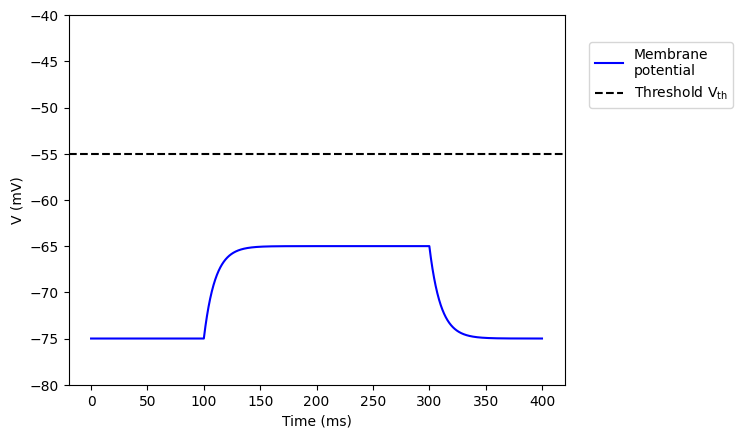

In [8]:
def run_LIF(pars, Iinj, stop=False):
    """
    Simulate the LIF dynamics with exteernal input current

    Args:
    :param pars: parameter dictionary
    :param Iinj: input current [pA]. The injected current here can be a value or an array
    :param stop: boolean. If True, use a current pulse

    Returns:
    :return rec_v: membrane potential
    :return rec_sp:spike times
    """

    # Set parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m, g_L = pars['tau_m'], pars['g_L']
    V_init, E_L = pars['V_init'], pars['E_L']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    tref = pars['tref']

    # Initialize voltage
    v = np.zeros(Lt)
    v[0] = V_init

    # Set current time course
    Iinj = Iinj * np.ones(Lt)

    # If current pulse, set beginning and end to zero
    if stop:
        Iinj[:int(len(Iinj) / 2) - 1000] = 0
        Iinj[int(len(Iinj) / 2) + 1000:] = 0

    # Loop over time
    rec_spikes = []    # record spike times
    tr = 0.    # the count for refractory duration

    for it in range(Lt-1):
        if tr > 0:
            v[it] = V_reset
            tr -= 1
            continue

        elif v[it] >= V_th:
            rec_spikes.append(it)
            v[it] = V_reset
            tr = tref / dt
            continue

        # Calculate the increment of the membrane potantial
        dv = (dt/tau_m) * (-(v[it] - E_L) + Iinj[it] / g_L)

        # Update the membrane potential
        v[it+1] = v[it] + dv

        # Get spike times in ms
    rec_spikes = np.array(rec_spikes) * dt

    return v, rec_spikes

# Get parameters
pars = default_pars(T=500)

# Simulate LIF model
v, sp = run_LIF(pars, Iinj=100, stop=True)

#Visualize
plot_volt_trace(pars, v, sp)

The figure shows the response of a LIF neuron to a subthreshold input current. \
The membrane potential increases and approaches a steady-state value,
but does not exceed the firing threshold; therefore, no spike is generated.\
After the input current is removed, the membrane potential passively
relaxes back to the resting potential $V_{reset}$.